In [1]:
import sys
import urllib
import requests
import numpy as np
import pandas as pd
from io import StringIO
from pandas import json_normalize

from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from _helpers import to_date_period, to_datetime
from _elexon_helpers import robust_request
from build_base import get_bids, get_offers, get_volumes, get_trades
# from build_base import build_physical_notifications_period

date = '2024-03-23'

In [2]:
from tqdm import tqdm

bs = list()
os = list()

for p in tqdm(range(1, 49)):
    bs.append(get_bids(date, p))
    os.append(get_offers(date, p))


  0%|          | 0/48 [00:00<?, ?it/s]

getting volumes for 2024-03-23 1
getting trades for 2024-03-23 1
Building bids for 2024-03-23 1


  2%|▏         | 1/48 [00:02<02:15,  2.88s/it]

Building offers for 2024-03-23 1
getting volumes for 2024-03-23 2
getting trades for 2024-03-23 2
Building bids for 2024-03-23 2
Building offers for 2024-03-23 2


  4%|▍         | 2/48 [00:05<02:00,  2.62s/it]

getting volumes for 2024-03-23 3
getting trades for 2024-03-23 3
Building bids for 2024-03-23 3
Building offers for 2024-03-23 3


  6%|▋         | 3/48 [00:07<01:56,  2.58s/it]

getting volumes for 2024-03-23 4
getting trades for 2024-03-23 4
Building bids for 2024-03-23 4


  8%|▊         | 4/48 [00:10<01:50,  2.52s/it]

Building offers for 2024-03-23 4
getting volumes for 2024-03-23 5
getting trades for 2024-03-23 5
Building bids for 2024-03-23 5
Building offers for 2024-03-23 5


 10%|█         | 5/48 [00:12<01:45,  2.44s/it]

getting volumes for 2024-03-23 6
getting trades for 2024-03-23 6
Building bids for 2024-03-23 6
Building offers for 2024-03-23 6


 12%|█▎        | 6/48 [00:15<01:49,  2.62s/it]

getting volumes for 2024-03-23 7
getting trades for 2024-03-23 7
Building bids for 2024-03-23 7
Building offers for 2024-03-23 7


 15%|█▍        | 7/48 [00:17<01:43,  2.53s/it]

getting volumes for 2024-03-23 8
getting trades for 2024-03-23 8
Building bids for 2024-03-23 8
Building offers for 2024-03-23 8


 17%|█▋        | 8/48 [00:20<01:41,  2.54s/it]

getting volumes for 2024-03-23 9
getting trades for 2024-03-23 9
Building bids for 2024-03-23 9
Building offers for 2024-03-23 9


 19%|█▉        | 9/48 [00:22<01:38,  2.53s/it]

getting volumes for 2024-03-23 10
getting trades for 2024-03-23 10
Building bids for 2024-03-23 10
Building offers for 2024-03-23 10


 21%|██        | 10/48 [00:25<01:36,  2.55s/it]

getting volumes for 2024-03-23 11
getting trades for 2024-03-23 11
Building bids for 2024-03-23 11
Building offers for 2024-03-23 11


 23%|██▎       | 11/48 [00:28<01:33,  2.53s/it]

getting volumes for 2024-03-23 12
getting trades for 2024-03-23 12
Building bids for 2024-03-23 12
Building offers for 2024-03-23 12


 25%|██▌       | 12/48 [00:30<01:29,  2.50s/it]

getting volumes for 2024-03-23 13
getting trades for 2024-03-23 13
Building bids for 2024-03-23 13
Building offers for 2024-03-23 13


 27%|██▋       | 13/48 [00:32<01:25,  2.45s/it]

getting volumes for 2024-03-23 14
getting trades for 2024-03-23 14
Building bids for 2024-03-23 14
Building offers for 2024-03-23 14


 29%|██▉       | 14/48 [00:35<01:21,  2.40s/it]

getting volumes for 2024-03-23 15
getting trades for 2024-03-23 15
Building bids for 2024-03-23 15
Building offers for 2024-03-23 15


 31%|███▏      | 15/48 [00:37<01:18,  2.38s/it]

getting volumes for 2024-03-23 16
getting trades for 2024-03-23 16
Building bids for 2024-03-23 16


 33%|███▎      | 16/48 [00:40<01:18,  2.45s/it]

Building offers for 2024-03-23 16
getting volumes for 2024-03-23 17
getting trades for 2024-03-23 17
Building bids for 2024-03-23 17
Building offers for 2024-03-23 17


 35%|███▌      | 17/48 [00:42<01:18,  2.54s/it]

getting volumes for 2024-03-23 18
getting trades for 2024-03-23 18
Building bids for 2024-03-23 18
Building offers for 2024-03-23 18


 38%|███▊      | 18/48 [00:45<01:17,  2.59s/it]

getting volumes for 2024-03-23 19
getting trades for 2024-03-23 19
Building bids for 2024-03-23 19
Building offers for 2024-03-23 19


 40%|███▉      | 19/48 [00:48<01:15,  2.60s/it]

getting volumes for 2024-03-23 20
getting trades for 2024-03-23 20
Building bids for 2024-03-23 20
Building offers for 2024-03-23 20


 42%|████▏     | 20/48 [00:50<01:12,  2.57s/it]

getting volumes for 2024-03-23 21
getting trades for 2024-03-23 21


 44%|████▍     | 21/48 [00:52<01:05,  2.42s/it]

Building bids for 2024-03-23 21
Building offers for 2024-03-23 21
getting volumes for 2024-03-23 22
getting trades for 2024-03-23 22


 46%|████▌     | 22/48 [00:54<00:59,  2.27s/it]

Building bids for 2024-03-23 22
Building offers for 2024-03-23 22
getting volumes for 2024-03-23 23
getting trades for 2024-03-23 23
Building bids for 2024-03-23 23
Building offers for 2024-03-23 23


 48%|████▊     | 23/48 [00:56<00:55,  2.21s/it]

getting volumes for 2024-03-23 24
getting trades for 2024-03-23 24
Building bids for 2024-03-23 24
Building offers for 2024-03-23 24


 50%|█████     | 24/48 [00:58<00:52,  2.20s/it]

getting volumes for 2024-03-23 25
getting trades for 2024-03-23 25


 52%|█████▏    | 25/48 [01:00<00:49,  2.17s/it]

Building bids for 2024-03-23 25
Building offers for 2024-03-23 25
getting volumes for 2024-03-23 26
getting trades for 2024-03-23 26
Building bids for 2024-03-23 26
Building offers for 2024-03-23 26


 54%|█████▍    | 26/48 [01:03<00:47,  2.15s/it]

getting volumes for 2024-03-23 27
getting trades for 2024-03-23 27
Building bids for 2024-03-23 27
Building offers for 2024-03-23 27


 56%|█████▋    | 27/48 [01:05<00:45,  2.17s/it]

getting volumes for 2024-03-23 28
getting trades for 2024-03-23 28


 58%|█████▊    | 28/48 [01:08<00:49,  2.47s/it]

Building bids for 2024-03-23 28
Building offers for 2024-03-23 28
getting volumes for 2024-03-23 29
getting trades for 2024-03-23 29


 60%|██████    | 29/48 [01:10<00:45,  2.41s/it]

Building bids for 2024-03-23 29
Building offers for 2024-03-23 29
getting volumes for 2024-03-23 30
getting trades for 2024-03-23 30


 62%|██████▎   | 30/48 [01:13<00:46,  2.56s/it]

Building bids for 2024-03-23 30
Building offers for 2024-03-23 30
getting volumes for 2024-03-23 31
getting trades for 2024-03-23 31


 65%|██████▍   | 31/48 [01:15<00:42,  2.47s/it]

Building bids for 2024-03-23 31
Building offers for 2024-03-23 31
getting volumes for 2024-03-23 32
getting trades for 2024-03-23 32
Building bids for 2024-03-23 32
Building offers for 2024-03-23 32


 67%|██████▋   | 32/48 [01:18<00:38,  2.41s/it]

getting volumes for 2024-03-23 33
getting trades for 2024-03-23 33
Building bids for 2024-03-23 33
Building offers for 2024-03-23 33


 69%|██████▉   | 33/48 [01:20<00:35,  2.36s/it]

getting volumes for 2024-03-23 34
getting trades for 2024-03-23 34
Building bids for 2024-03-23 34
Building offers for 2024-03-23 34


 71%|███████   | 34/48 [01:23<00:35,  2.52s/it]

getting volumes for 2024-03-23 35
getting trades for 2024-03-23 35
Building bids for 2024-03-23 35
Building offers for 2024-03-23 35


 73%|███████▎  | 35/48 [01:26<00:33,  2.57s/it]

getting volumes for 2024-03-23 36
getting trades for 2024-03-23 36
Building bids for 2024-03-23 36
Building offers for 2024-03-23 36


 75%|███████▌  | 36/48 [01:28<00:31,  2.61s/it]

getting volumes for 2024-03-23 37
getting trades for 2024-03-23 37
Building bids for 2024-03-23 37
Building offers for 2024-03-23 37


 77%|███████▋  | 37/48 [01:31<00:28,  2.59s/it]

getting volumes for 2024-03-23 38
getting trades for 2024-03-23 38
Building bids for 2024-03-23 38
Building offers for 2024-03-23 38


 79%|███████▉  | 38/48 [01:33<00:25,  2.53s/it]

getting volumes for 2024-03-23 39
getting trades for 2024-03-23 39
Building bids for 2024-03-23 39
Building offers for 2024-03-23 39


 81%|████████▏ | 39/48 [01:35<00:21,  2.44s/it]

getting volumes for 2024-03-23 40
getting trades for 2024-03-23 40
Building bids for 2024-03-23 40
Building offers for 2024-03-23 40


 83%|████████▎ | 40/48 [01:38<00:19,  2.41s/it]

getting volumes for 2024-03-23 41
getting trades for 2024-03-23 41
Building bids for 2024-03-23 41
Building offers for 2024-03-23 41


 85%|████████▌ | 41/48 [01:40<00:16,  2.43s/it]

getting volumes for 2024-03-23 42
getting trades for 2024-03-23 42
Building bids for 2024-03-23 42
Building offers for 2024-03-23 42


 88%|████████▊ | 42/48 [01:43<00:14,  2.40s/it]

getting volumes for 2024-03-23 43
getting trades for 2024-03-23 43
Building bids for 2024-03-23 43
Building offers for 2024-03-23 43


 90%|████████▉ | 43/48 [01:45<00:12,  2.42s/it]

getting volumes for 2024-03-23 44
getting trades for 2024-03-23 44
Building bids for 2024-03-23 44
Building offers for 2024-03-23 44


 92%|█████████▏| 44/48 [01:48<00:10,  2.66s/it]

getting volumes for 2024-03-23 45
getting trades for 2024-03-23 45
Building bids for 2024-03-23 45
Building offers for 2024-03-23 45


 94%|█████████▍| 45/48 [01:50<00:07,  2.52s/it]

getting volumes for 2024-03-23 46
getting trades for 2024-03-23 46
Building bids for 2024-03-23 46
Building offers for 2024-03-23 46


 96%|█████████▌| 46/48 [01:53<00:04,  2.47s/it]

getting volumes for 2024-03-23 47
getting trades for 2024-03-23 47
Building bids for 2024-03-23 47
Building offers for 2024-03-23 47


 98%|█████████▊| 47/48 [01:55<00:02,  2.43s/it]

getting volumes for 2024-03-23 48
getting trades for 2024-03-23 48
Building bids for 2024-03-23 48
Building offers for 2024-03-23 48


100%|██████████| 48/48 [01:57<00:00,  2.46s/it]


In [3]:
bdf = pd.concat(bs, axis=1)
odf = pd.concat(os, axis=1)

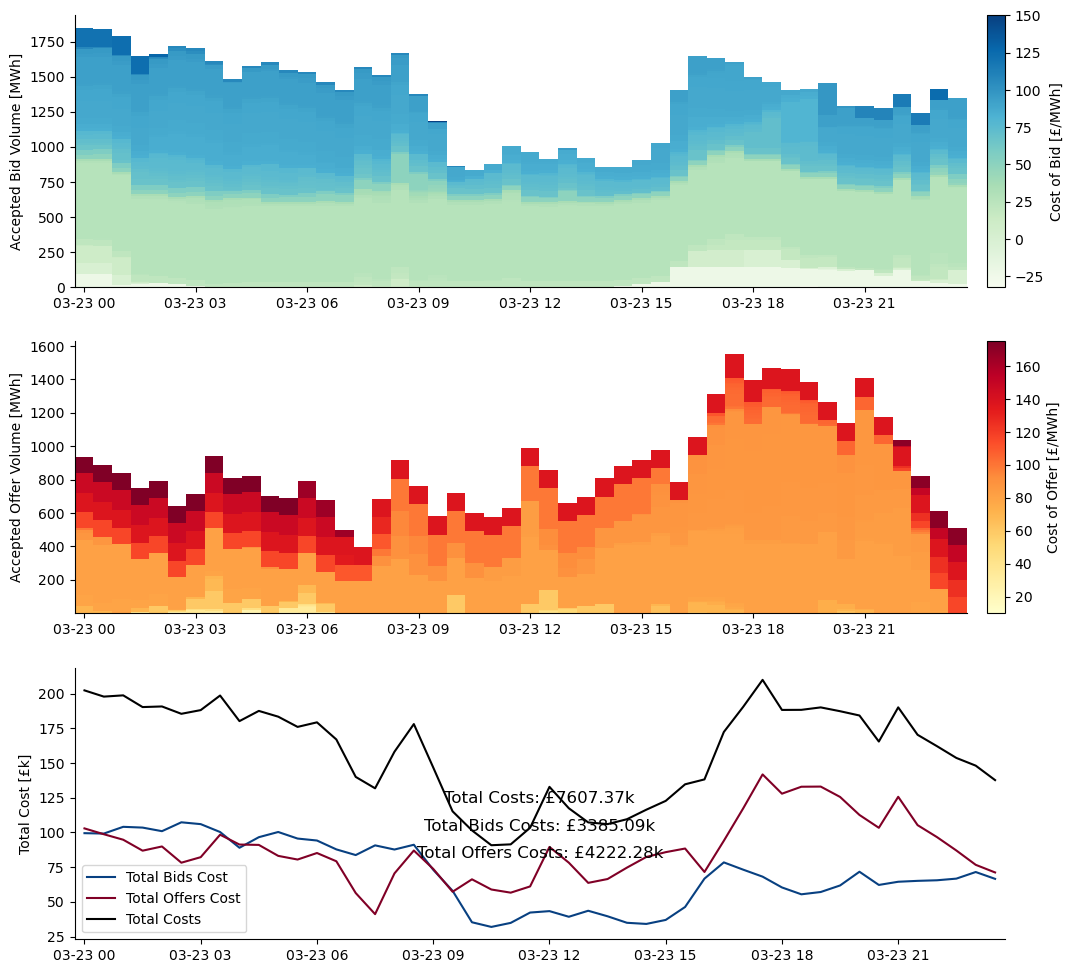

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = pd.IndexSlice

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

bmin = bdf.loc[:, idx[:, 'price']].min().min()
bmax = bdf.loc[:, idx[:, 'price']].max().max()
bnorm = mcolors.Normalize(vmin=bmin, vmax=bmax)
bmap = plt.cm.GnBu

for i, dt in enumerate(bdf.columns.get_level_values(0).unique()):
    ss = bdf.loc[:, idx[dt, :]].dropna()
    ss.columns = ss.columns.droplevel(0)

    ss = ss.sort_values(by='price')

    ss['cumsum'] = ss['vol'].abs().cumsum()
    
    try:
        ss['cumsum_lower'] = ss['cumsum'] - ss['vol'].iloc[0]
    except IndexError:
        continue

    for _, row in ss.iterrows():
        c = bmap(bnorm(row['price']))
        axs[0].bar(
            dt,
            row['vol'],
            bottom=row['cumsum'] - row['vol'],
            color=c,
            width=1/48,
            )


omin = odf.loc[:, idx[:, 'price']].min().min()
omax = odf.loc[:, idx[:, 'price']].max().max()
onorm = mcolors.Normalize(vmin=omin, vmax=omax)
omap = plt.cm.YlOrRd

for i, dt in enumerate(odf.columns.get_level_values(0).unique()):
    ss = odf.loc[:, idx[dt, :]].dropna()
    ss.columns = ss.columns.droplevel(0)

    ss = ss.sort_values(by='price')

    ss['cumsum'] = ss['vol'].abs().cumsum()

    try:
        ss['cumsum_lower'] = ss['cumsum'] - ss['vol'].iloc[0]
    except IndexError:
        continue

    for _, row in ss.iterrows():
        c = omap(onorm(row['price']))
        axs[1].bar(
            dt,
            row['vol'],
            bottom=row['cumsum'] - row['vol'],
            color=c,
            width=1/48,
            )

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="2%", pad=0.2)

sm = plt.cm.ScalarMappable(cmap=bmap, norm=bnorm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Cost of Bid [£/MWh]')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="2%", pad=0.2)

sm = plt.cm.ScalarMappable(cmap=omap, norm=onorm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Cost of Offer [£/MWh]')


axs[0].set_ylabel('Accepted Bid Volume [MWh]')
axs[1].set_ylabel('Accepted Offer Volume [MWh]')


total_bids_costs = []
total_offers_costs = []

for i, dt in enumerate(bdf.columns.get_level_values(0).unique()):

    bids = bdf.loc[:, idx[dt, :]].dropna()
    bids.columns = bids.columns.droplevel(0)

    offers = odf.loc[:, idx[dt, :]].dropna()
    offers.columns = offers.columns.droplevel(0)

    total_bids_costs.append((bids['vol'] * bids['price']).sum())
    total_offers_costs.append((offers['vol'] * offers['price']).sum())

total_bids_costs = pd.Series(total_bids_costs, index=bdf.columns.get_level_values(0).unique()).mul(1e-3)
total_offers_costs = pd.Series(total_offers_costs, index=odf.columns.get_level_values(0).unique()).mul(1e-3)
total_costs = total_bids_costs + total_offers_costs

axs[2].plot(total_bids_costs.index, total_bids_costs, color=bmap(bnorm(bmax)), label='Total Bids Cost')
axs[2].plot(total_offers_costs.index, total_offers_costs, color=omap(onorm(omax)), label='Total Offers Cost')
axs[2].plot(total_costs.index, total_costs, label='Total Costs', color='black')
axs[2].legend()
axs[2].set_ylabel('Total Cost [£k]')

axs[2].text(0.5, 0.4, 'Total Bids Costs: £{:.2f}k'.format(total_bids_costs.sum()), transform=axs[2].transAxes, fontsize=12, ha='center')
axs[2].text(0.5, 0.3, 'Total Offers Costs: £{:.2f}k'.format(total_offers_costs.sum()), transform=axs[2].transAxes, fontsize=12, ha='center')
axs[2].text(0.5, 0.5, 'Total Costs: £{:.2f}k'.format(total_costs.sum()), transform=axs[2].transAxes, fontsize=12, ha='center')

for ax in axs:

    xmin = bdf.columns.get_level_values(0).min() - pd.Timedelta('15min')
    xmax = bdf.columns.get_level_values(0).max() + pd.Timedelta('15min')

    ax.set_xlim(xmin, xmax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [38]:
bdf.to_csv('bids.csv')

In [39]:
bdf.to_csv('bids.parquet')

In [25]:
viable = bdf.loc[:,idx[:, 'price']].isna().sum(axis=1)

viable = viable.loc[viable < (bdf.shape[1] - 4)].index

In [28]:

print(bdf.loc[viable, idx[:,'price']].mean(axis=1))
m = bdf.loc[viable, idx[:,'price']].mean(axis=1)

print(bdf.loc[viable, idx[:,'price']].std(axis=1))
s = bdf.loc[viable, idx[:,'price']].std(axis=1)

AG-PEDF01    23.7500
AG-ZEN03J    24.0000
BABAW-1      71.5000
BHLAW-1      86.9300
BNWKW-1      93.0000
              ...   
MOWEO-1      82.6700
MOWEO-2      84.5850
MOWEO-3      84.5475
AG-PFLX01    35.0000
PILLB-1      16.2050
Length: 149, dtype: float64
AG-PEDF01    3.535534e+00
AG-ZEN03J    5.163978e+00
BABAW-1      0.000000e+00
BHLAW-1      5.794807e-14
BNWKW-1      0.000000e+00
                 ...     
MOWEO-1      9.970729e+00
MOWEO-2      9.407116e+00
MOWEO-3      1.064957e+01
AG-PFLX01    0.000000e+00
PILLB-1      1.166726e+00
Length: 149, dtype: float64


HAWKB-1      50.611901
WISHB-1      34.916933
BHOLB-1      32.949697
THMRB-1      30.962076
BROAB-1      29.605177
               ...    
AG-HLIM01          NaN
AG-HLIM02          NaN
AG-GSTK05          NaN
AG-HLIM04          NaN
DINO-5             NaN
Length: 149, dtype: float64


<AxesSubplot:ylabel='Frequency'>

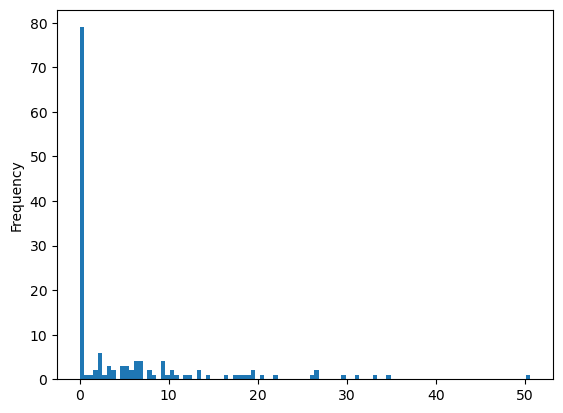

In [33]:
print(s.sort_values(axis=0, ascending=False))
s.plot.hist(bins=100)